In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from pde_functions import PDE_plotter_1D
import time
from IPython.display import display, clear_output

## 1D (Linear) Wave Equation is a Linear Hyperbolic PDE:
## $u_{tt} = c^{2}u_{xx}, \tiny\text{where c = a constant}$

### Initial Conditions and Boundary Conditions
- Both BC and IC are set directly here in these functions
- IC currently set to create a Gaussian spike around xc with width w (set using **kwargs)
    - Gaussian spike = $\exp\left(-\frac{(x - x_c)^2}{w^2}\right)$
- BCs are zero at both ends

In [2]:
# Initial Condition Functions
def f_u_0_x(x_grid,**kwargs):
    '''
    Assigns the initial values (t=0) for U, inner nodes.
    If the initial value is a constant, leave function as-is.
    If the initial value is a function of x, replace return value with function.
    
    Parameters: 
    **kwargs - Enter in any arguments necessary for the function to run.
    '''
    # Create Data Holder - same size as x_grid
    u_t_x_0 = np.zeros_like(x_grid)
    
    # Loop through grid locations and assign initial values
    for i, x in enumerate(x_grid):
        u_t_x_0[i] = (np.exp(-(x-xc)**2/w**2))
        
    return u_t_x_0
    
def f_u_t_0(t):
    '''
    Assigns the initial value for the 0-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float]    
    '''    
    return 0

def f_u_t_L(t):
    '''
    Assigns the initial value for the L-boundary.
    If the boundary is a constant value, leave function as-is.
    If boundary is a function of t, replace return value with function.
    
    Parameters: t = time [Float] 
    '''
    return 0

### Explicit Solver Function

In [3]:
def wave_1D_explicit_timestep(u_line,u_line_previous,c,m,dt,dx):
    '''
    Takes in:
    u_line [1D array] - Values of the wave equation at time now (used to rpedict next step)
    u_line_previous [1d array] - Values of the wave equation at the previous step
    m [int] - The space index being examined
    dt [float] - Time step
    dx [float] - X step
    
    Returns:
    The next time evolution step of the 1D linear wave equation.
    
    Uses Centered Finite Difference Approximations in Space and Time to determine the evolution of the wave
    equation.
    '''
    
    return (dt**2/dx**2) * c**2 * (u_line[m+1] + u_line[m-1] - 2*u_line[m]) + 2*u_line[m] - u_line_previous[m]

### Parameters
Along with IC and BC, these parameters need to be set by the user

In [4]:
# Wave Domain Information
L = 1 # Length, in units long
t_max = 5 # Time in seconds

# Domain step size
dx = .01 # Space step is .01 length units

# Wave propogation speed
c = .5 # Length units per second

# Initial Parameters for Gaussian Pulse 
xc = L/2 # Where from 0 to L the pulse is centered
w = .1 # The Gaussian Pulse width

### Run this cell to create the discretized array which solves the PDE

In [5]:
# Creates a dt that meets CFL conditions
dt = dx/c * .5 # Added the .5 factor to ensure well below the CFL, not just at it

# Calculates node number
Nx = int(L/dx) + 1 # Add an extra node to include x at L, remove later
Nt = int(t_max/dt) + 1 #Add an extra node to include t at t_max, remove later

# Creates node grids
x_grid = np.linspace(0,L,Nx)
t_grid = np.linspace(0,t_max,Nt)

# Creates solution data holder
U = np.zeros([len(t_grid),len(x_grid)])

# Appends initial conditions (t = 0)
u_t_x_0 = f_u_0_x(x_grid,xc = xc,w = w)

# Boundary Conditions
u_t_x_0[0] = f_u_t_0(0)
u_t_x_0[-1] = f_u_t_L(0)

U[0:2,:] = u_t_x_0 # Fills first two lines of U with initial conditions

# Evolves the wave through the rest of the time steps
for t in range(2,len(t_grid)):    
    for x in range(1,len(x_grid)-1):
        U[t,x] = wave_1D_explicit_timestep(U[t-1],U[t-2],c,x,dt,dx)

    # Append the first and last value with boundary conditions (0 in this case)
    U[t,0] = f_u_t_0(0)
    U[t,L] = f_u_t_L(0)

### Plot Using Custom Plotting Function
#### IMPORTANT - Run plotting function at the [bottom of the notebook](#Plotter:) first.


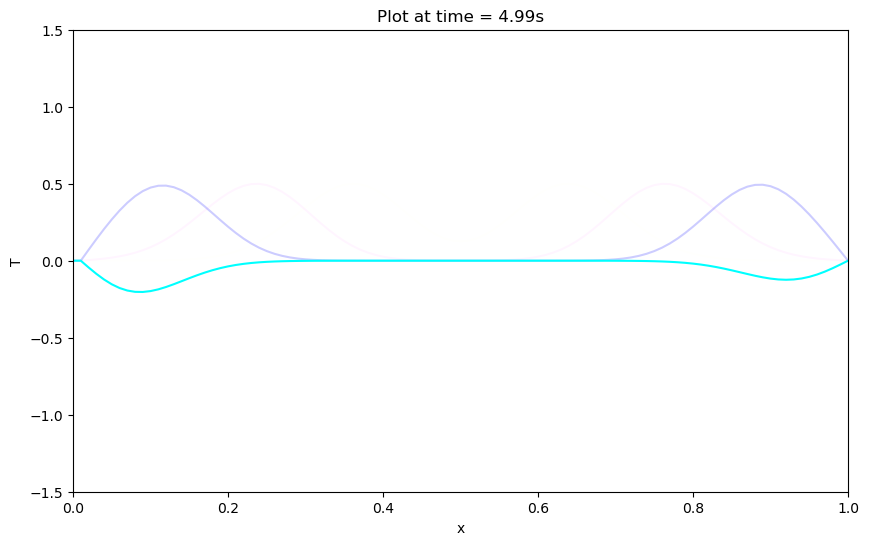

In [7]:
steps = 20 # How many time snapshots to show 
t_min_plot = 0       # default = 0
t_max_plot = t_max       # default = len()
x_min_plot = 0       # default = 0
x_max_plot = L     # default = L_6
alpha_decay = .2  # How fast the previous wave plots disappear (helps visualize wave)
 
# Grapher
PDE_plotter_1D(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay)

----

### Plotter:

In [6]:
def PDE_plotter_1D(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, alpha_decay = .7, style = 'multi'):
    '''
    Function takes in calculated 1D data changing over time
    array of lists, the outer array holding timesteps and the inner a
    '''
    # Check for Errors
    if t_max_plot > t_max:
        raise Exception('Plotting end time exceeds maximum time')
    if t_min_plot < 0:
        raise Exception('Plotting start time must be greater than 0')
    if t_min_plot >= t_max_plot:
        raise Exception('Max plot time greater than minimum plot time')
    if x_min_plot < 0:
        raise Exception('Minimum x plot less than left boundary')
    if x_max_plot > L:
        raise Exception('Mamimum x plot larger than the right boundary')
    if x_min_plot >= x_max_plot:
        raise Exception('Invalid x value plotting range')
    

    dt = t_max/len(U)
    t_min_index = int(t_min_plot / dt)
    #*#t_max_index = int(t_max_plot / dt)
    t_max_index = int(t_max_plot / dt) + 1
    print('t_min_index:',t_min_index)
    print('t_max_index:',t_max_index)
    
    dx = L/len(U[0])
    x_min_index = int(x_min_plot / dx)
    x_max_index = int(x_max_plot / dx)
    print('x_min_index:',x_min_index)
    print('x_max_index:',x_max_index)

    # Create slice to analyze
    U_slice = U[t_min_index:t_max_index]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('x')  # Set x-axis label
    ax.set_ylabel('T')  # Set y-axis label

    # Set the y-axis limits
    y_min = min([min(u) for u in U_slice]) - 0.5  # Find the minimum y-value in U with some buffer
    y_max = max([max(u) for u in U_slice]) + 0.5  # Find the maximum y-value in U with some buffer
    ax.set_ylim(y_min, y_max)

    # Set the x-axis limits
    ax.set_xlim(x_min_plot, x_max_plot)
    
    lines = []  # List to store line objects

    plt.show()
    
    interval = len(U_slice)//steps

    color_counter = 5
   
    for i in np.arange(0, len(U_slice), interval):
        # Update the alpha values of existing lines
        
        for line in lines:
            line.set_alpha(line.get_alpha() * alpha_decay)
    
        # Compute scaled x-axis values
        x_values = np.linspace(0, L, len(U_slice[i]))
        x_values_used = x_values[x_min_index:x_max_index+1]
        
        # Add new line
        if style == 'heat':
            line_color = 'red'
        if style == 'multi':
            line_color = ['cyan','green','yellow','magenta','blue'][color_counter%5]
            color_counter += 1

        new_line, = ax.plot(x_values_used,U_slice[i][x_min_index:x_max_index+1], color=line_color, alpha=1)  # Start with full opacity
        lines.append(new_line)  # Store the new line object
        #ax.set_title(f"Plot at time = {i/(len(U_slice)-1)}s")  # Update the title with the current step
        ax.set_title(f"Plot at time = {round(t_min_plot + i*dt,3)}s")
        
        
        # Handling plot display
        clear_output(wait=True)  # Clear the previous plot
        display(fig)  # Display the current figure

        time.sleep(0.25)  # Pause for half a second before the next update 